先预训练一个小版本的BERT，然后微调，在SNLI数据集上进行自然语言推断

另外参考：
【动手学习pytorch笔记】37.5 BERT微调：https://blog.csdn.net/ymk1998/article/details/124641889

In [1]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

bert有bert.base和bert.small

In [2]:
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

训练好的bert模型包含一个定义词表“vocab.json”文件和
另一个预训练参数的“pretrained.params”文件

In [3]:
def load_pretrained_model(
    pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, 
    num_layers, dropout,max_len, devices):
    # 下载并解压预训练模型
    data_dir = d2l.download_extract(pretrained_model)
    
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(
        open(
            os.path.join(data_dir, 'vocab.json')
        )
    )
    vocab.token_to_idx = {
        token: idx for idx,token in enumerate(vocab.idx_to_token)
    }
    bert = d2l.BERTModel(
        len(vocab),
        num_hiddens,
        norm_shape=[256],
        ffn_num_input=256,
        ffn_num_hiddens=ffn_num_hiddens,
        num_heads=4,
        num_layers=2,
        dropout=0.2,
        max_len=max_len,
        key_size=256,
        query_size=256,
        value_size=256,
        hid_in_features=256,
        mlm_in_features=256,
        nsp_in_features=256
    )
    # 加载预训练BERT参数
    bert.load_state_dict(
        torch.load(
            os.path.join(data_dir, 'pretrained.params')
        )
    )
    return bert, vocab

```
def load_pretrained_model(
    pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, 
    num_layers, drop_out,max_len, devices
)
```
您提供的`load_pretrained_model`函数参数看起来像是用于加载BERT预训练模型时的一些配置参数。不过，您给出的参数列表并不完全符合标准的BERT模型加载函数的参数，因此我会基于这些参数名称来推测它们可能代表的含义：

1. **pretrained_model**: 这应该是预训练BERT模型的路径或者标识符，用来定位模型文件，以便加载。

2. **num_hiddens**: 这可能指的是BERT模型中隐藏层（hidden layer）的维度大小。BERT模型中的每个Transformer层都有一个隐藏状态，其维度大小通常是一个固定的值，如768、1024等。

3. **ffn_num_hiddens**: 这代表BERT模型中前馈神经网络（Feed-Forward Network，FFN）内部的隐藏层大小。BERT中的每个Transformer层都包含一个FFN，其内部隐藏层的大小通常比隐藏状态的大小要大（例如，3072对于768的隐藏状态大小）。

4. **num_heads**: 这是BERT模型中多头自注意力机制（Multi-Head Attention）的“头”的数量。多头自注意力机制允许模型同时关注输入序列的不同部分，从而增强模型的表示能力。

5. **num_layers**: 这代表BERT模型中的Transformer层的数量。BERT模型由多个堆叠的Transformer层组成，这个参数指定了堆叠的层数。

6. **drop_out**: 这是BERT模型中的dropout率，用于防止过拟合。在训练过程中，dropout层会随机丢弃一部分神经元的输出，这样可以帮助模型更加鲁棒。

7. **max_len**: 这代表模型处理的最大序列长度。BERT模型在处理输入时，会将输入序列截断或填充到这个长度。

8. **devices**: 这可能是用于指定模型应该在哪些设备（如CPU或GPU）上运行的参数。它可以是一个设备标识符（如`'cuda:0'`）或设备列表，用于分布式训练或并行计算。

需要注意的是，这些参数的具体含义和用途可能依赖于具体的BERT实现库或框架。不同的库和框架可能有不同的参数命名和用法。因此，如果您正在使用特定的BERT实现，最好查阅该实现的文档以获取准确的参数解释。

---
bert微调中定义词表vocab.json是什么

在BERT（Bidirectional Encoder Representations from Transformers）的微调（fine-tuning）过程中，`vocab.json`文件是一个非常重要的组件，它定义了BERT模型所使用的词汇表（vocabulary）。

BERT模型是在大量的文本数据上进行预训练的，这些数据首先会被转换为模型的输入格式，也就是一系列的token IDs。`vocab.json`文件就是用来定义这些token与它们对应的ID之间映射关系的。

具体来说，`vocab.json`是一个JSON格式的文件，其中包含了模型词汇表中的所有token（例如单词、标点符号等）及其对应的ID。这些token通常是根据训练数据的统计信息（如词频）来选择的，以确保模型能够有效地处理各种文本数据。

在微调BERT模型时，你需要使用与预训练模型相同的`vocab.json`文件，以确保模型的输入和输出与预训练阶段保持一致。这样，微调过程就可以充分利用预训练阶段学到的知识，并在特定的任务上进行进一步的优化。

此外，除了`vocab.json`文件外，BERT模型通常还会配有一个`vocab.txt`文件（或其他类似格式的文件），它包含了与`vocab.json`相同的信息，但格式可能更易于人类阅读。这个文件通常用于一些需要直接查看词汇表的工具或任务中。

---
```
vocab.token_to_idx = {
        token: idx for idx,token in enumerate(vocab.idx_to_token)
    }
```
在这段代码中，`vocab.token_to_idx` 是一个字典，它映射词汇表中的每个单词（token）到其对应的索引（idx）。这个映射对于将文本转换为模型可以理解的数字序列（即token IDs）非常重要。

这里使用了一个字典推导式（dictionary comprehension）来创建这个映射。字典推导式是Python中一种简洁地创建字典的方法。

代码：


```python
vocab.token_to_idx = {
    token: idx for idx, token in enumerate(vocab.idx_to_token)
}
```
解释：

1. `enumerate(vocab.idx_to_token)`：`enumerate` 函数会遍历 `vocab.idx_to_token`（这是一个从索引到单词的映射）并返回每个元素的索引和值。
2. `for idx, token in enumerate(vocab.idx_to_token)`：这个循环遍历上面提到的 `enumerate` 函数的输出，将索引赋值给 `idx`，将单词赋值给 `token`。
3. `token: idx`：在字典推导式中，这表示创建一个新的键值对，其中键是 `token`（单词），值是 `idx`（索引）。

因此，整个字典推导式遍历 `vocab.idx_to_token`，并为每个单词创建一个从单词到索引的映射，然后将这个映射存储在 `vocab.token_to_idx` 中。

最终，`vocab.token_to_idx` 将成为一个从单词到索引的映射，与 `vocab.idx_to_token`（从索引到单词的映射）是相反的。这样，当你知道一个单词并想找到它的索引时，你可以使用 `vocab.token_to_idx`；当你有一个索引并想找到对应的单词时，你可以使用 `vocab.idx_to_token`。

In [4]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small',
    num_hiddens=256,
    ffn_num_hiddens=512,
    num_heads=4,
    num_layers=2,
    dropout=0.1,
    max_len=512,
    devices=devices
)

微调BERT的数据集

In [5]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        # print("1.1")
        all_premise_hypothesis_tokens = [
            [p_tokens, h_tokens] for p_tokens, h_tokens in zip(
                *[
                    d2l.tokenize(
                        [
                            s.lower() for s in sentences
                        ]
                    ) for sentences in dataset[:2]
                ]
            )
        ]
        # print("1.2")
        self.labels = torch.tensor(dataset[2])
        # print("1.3")
        self.vocab = vocab
        # print("1.4")
        self.max_len = max_len
        (
            self.all_token_ids,
            self.all_segments,
            self.valid_lens
        ) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')
    def _preprocess(self, all_premise_hypothesis_tokens):
        # print("1.5")
        # pool = multiprocessing.Pool(4) # 使用4个进程
        # out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        out = map(self._mp_worker, all_premise_hypothesis_tokens)
        # print("1.5.1")
        out = list(out)
        # print("1.6")
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out
        ]
        # print("1.7")
        all_segments = [segments for token_ids, segments, valid_len in out]
        # print("1.8")
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        # print("1.9")
        return (
            torch.tensor(all_token_ids, dtype=torch.long),
            torch.tensor(all_segments, dtype=torch.long),
            torch.tensor(valid_lens)
        )
    def _mp_worker(self, premise_hypothesis_tokens):
        
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
        
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len
    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入的“<CLS>”，“<SEP>”和“<SEP>”词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
    def __getitem__(self, idx):
        return (
            self.all_token_ids[idx],
            self.all_segments[idx],
            self.valid_lens[idx]
        ), self.labels[idx]
    def __len__(self):
        return len(self.all_token_ids)

```
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            [p_tokens, h_tokens] for p_tokens, h_tokens in zip(
                *[
                    d2l.tokenize(
                        [
                            s.lower() for s in sentences
                        ]
                    ) for sentences in dataset[:2]
                ]
            )
        ]

```
这段代码定义了一个名为 `SNLIBERTDataset` 的类，该类继承自 `torch.utils.data.Dataset`。`torch.utils.data.Dataset` 是 PyTorch 中用于表示数据集的基类，用于提供自定义数据集的方式。`SNLIBERTDataset` 类似乎是为了处理 SNLI (Stanford Natural Language Inference) 数据集而设计的，特别是与 BERT 模型结合使用时。

现在，我会逐行解释这段代码：

1. `class SNLIBERTDataset(torch.utils.data.Dataset):`


	* 这行代码定义了一个新类 `SNLIBERTDataset`，它继承自 PyTorch 的 `Dataset` 类。
2. `def __init__(self, dataset, max_len, vocab=None):`


	* 这是类的初始化方法。当你创建 `SNLIBERTDataset` 类的一个实例时，这个方法会被调用。
	* `dataset`: 预期是一个包含文本数据的列表或类似结构。
	* `max_len`: 文本序列的最大长度，可能是为了后续处理时统一长度。
	* `vocab`: 一个可选的词汇表，可能用于后续的文本编码。
3. `all_premise_hypothesis_tokens = [...]`


	* 这行代码开始定义 `all_premise_hypothesis_tokens`，它似乎是一个列表，其中每个元素都是一个包含两个列表的元组。这两个列表分别代表前提（premise）和假设（hypothesis）的标记化（tokenized）文本。
4. `[p_tokens, h_tokens] for p_tokens, h_tokens in zip(...)`


	* 这是一个列表推导式，用于从 `dataset` 中提取前提和假设的标记化文本。
5. `*[... for sentences in dataset[:2]]`


	* 这部分代码对 `dataset` 的前两个元素（即两组前提和假设）进行迭代。`dataset[:2]` 获取 `dataset` 的前两个元素。
6. `d2l.tokenize([s.lower() for s in sentences])`


	* 对于每一组前提和假设，首先通过列表推导式 `[s.lower() for s in sentences]` 将每个句子转换为小写。
	* 然后，使用 `d2l.tokenize` 函数（可能来自某个库或自定义函数）对这些小写句子进行标记化。

最后，`all_premise_hypothesis_tokens` 应该是一个列表，其中每个元素都是一个包含两个列表的元组：第一个列表是前提的标记化文本，第二个列表是假设的标记化文本。

需要注意的是，这段代码似乎有一些问题或遗漏：

* 它只处理了 `dataset` 的前两个元素，而不是整个数据集。
* `max_len` 和 `vocab` 在这个初始化方法中并没有被使用。

你可能需要进一步完善这个类，以便它能够处理整个数据集，并可能包括一些额外的功能，如根据 `max_len` 截断文本，使用 `vocab` 对文本进行编码等。

---
```
    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4) # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out
        ]
```
在这段代码中，`out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)` 这行使用 Python 的 `multiprocessing` 模块来并行处理数据。这里的核心概念是使用多进程（在这个例子中是4个进程）来加速数据预处理的过程。

详细解释如下：

1. **`multiprocessing.Pool(4)`**：
   创建一个包含4个进程的进程池。这意味着你可以同时运行4个任务（在这个上下文中，是数据预处理任务）而不必等待一个任务完成后再开始下一个。

2. **`pool.map(self._mp_worker, all_premise_hypothesis_tokens)`**：
   使用 `map` 函数来并行应用 `self._mp_worker` 函数到 `all_premise_hypothesis_tokens` 列表中的每一个元素上。

   - `self._mp_worker` 是一个函数，它预期接收 `all_premise_hypothesis_tokens` 中的一个元素（即一对前提和假设的标记化文本）作为输入，并返回一些处理后的数据（在这个例子中是 `token_ids`, `segments`, 和 `valid_len`）。
   - `all_premise_hypothesis_tokens` 是一个列表，其中每个元素都是一对前提和假设的标记化文本。

3. **`out`**：
   `out` 是一个列表，其长度与 `all_premise_hypothesis_tokens` 相同，其中每个元素都是 `self._mp_worker` 函数对应输入的处理结果。因为 `map` 函数是并行执行的，所以 `out` 的填充会比单线程执行更快。

4. **`all_token_ids = [token_ids for token_ids, segments, valid_len in out]`**：
   这行代码是一个列表推导式，它从 `out` 中提取所有的 `token_ids`，并将它们放入一个新的列表 `all_token_ids` 中。

这样做的好处是，如果你的数据集很大，使用多进程可以显著加速数据预处理的速度，因为多个任务可以同时运行，而不是一个接一个地运行。

需要注意的是，使用多进程时需要小心处理共享资源（例如全局变量）和进程间的通信，以确保数据的一致性和正确性。此外，由于创建和管理进程有一定的开销，因此对于非常小的数据集，使用多进程可能并不会带来明显的性能提升。

---
```
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
```
在这段代码中，`p_tokens, h_tokens = premise_hypothesis_tokens` 和 `self._truncate_pair_of_tokens(p_tokens, h_tokens)` 这两行代码的含义如下：

1. `p_tokens, h_tokens = premise_hypothesis_tokens`

   这行代码执行的是元组解包操作。它假设 `premise_hypothesis_tokens` 是一个包含两个元素的元组，其中第一个元素代表前提（premise）的标记化（tokenized）文本（即`p_tokens`），第二个元素代表假设（hypothesis）的标记化文本（即`h_tokens`）。通过解包操作，这两个元素被分别赋值给 `p_tokens` 和 `h_tokens` 变量。

   注意：这里有一个潜在的问题，即`premise_hypothesis_tokens` 应该确实是一个包含两个元素的元组，并且这两个元素分别对应前提和假设的标记化文本。如果`premise_hypothesis_tokens`的结构不符合这个预期，那么这行代码将会引发错误。

2. `self._truncate_pair_of_tokens(p_tokens, h_tokens)`

   这行代码调用了 `_truncate_pair_of_tokens` 方法，并将 `p_tokens` 和 `h_tokens` 作为参数传递。这个方法的目的很可能是对这两个标记化文本进行截断操作，以确保它们的长度不超过某个预设的最大长度（即 `self.max_len`）。具体的截断逻辑应该是在 `_truncate_pair_of_tokens` 方法的实现中定义的。

   注意：在代码中并没有给出 `_truncate_pair_of_tokens` 方法的具体实现，因此无法确定它具体的行为和工作方式。通常情况下，截断操作可能包括删除超出最大长度的标记，或者在达到最大长度时添加特殊的截断标记。

综上所述，这两行代码的作用是从输入的元组中提取前提和假设的标记化文本，并调用一个方法来对它们进行截断处理。但是，代码的质量和正确性还取决于其他部分（如 `_truncate_pair_of_tokens` 方法的实现）和上下文环境（如 `premise_hypothesis_tokens` 的确切结构和内容）。

---
```
    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len
```
这段 `_mp_worker` 函数是定义在 `SNLIBERTDataset` 类中的一个方法，它的目的是处理一对前提（premise）和假设（hypothesis）的标记化（tokenized）文本。这个函数会进行以下几个步骤的操作：

1. **解包前提和假设的标记化文本**:
   ```python
   p_tokens, h_tokens = premise_hypothesis_tokens
   ```
   这里假设 `premise_hypothesis_tokens` 是一个包含两个元素的元组，分别对应前提和假设的标记化文本。通过解包操作，这两个元素被分别赋值给 `p_tokens` 和 `h_tokens` 变量。

2. **截断前提和假设的标记化文本**:
   ```python
   self._truncate_pair_of_tokens(p_tokens, h_tokens)
   ```
   调用 `_truncate_pair_of_tokens` 方法来确保 `p_tokens` 和 `h_tokens` 的长度不会超过某个预设的最大长度（通常在类的初始化方法中定义）。这是为了适应模型输入的要求，因为大多数模型都需要固定长度的输入。

3. **获取标记和片段信息**:
   ```python
   tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
   ```
   这里调用了一个外部函数 `d2l.get_tokens_and_segments` 来获取处理后的标记（tokens）和对应的片段（segments）信息。在BERT等模型中，片段信息用于区分句子对中的不同句子，以便模型能够区分它们。

4. **将标记转换为标记ID并填充**:
   ```python
   token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
   ```
   使用词汇表（vocab）将标记转换为对应的ID。然后，如果标记的数量少于最大长度 `self.max_len`，则在ID列表的末尾填充特殊的 `<pad>` 标记的ID，直到达到最大长度。

5. **填充片段信息**:
   ```python
   segments = segments + [0] * (self.max_len - len(segments))
   ```
   同样地，如果片段信息的数量少于最大长度，则在列表的末尾填充0，直到达到最大长度。

6. **获取有效长度**:
   ```python
   valid_len = len(tokens)
   ```
   有效长度（`valid_len`）是指未填充前的标记数量。这对于后续计算模型损失等步骤是很重要的，因为模型应该只关注那些非填充的标记。

7. **返回处理后的数据**:
   ```python
   return token_ids, segments, valid_len
   ```
   函数最后返回处理后的标记ID、片段信息和有效长度。

这个函数通常在一个多进程环境中被调用，用于并行处理多个前提和假设对，以加快数据预处理的速度。返回的数据随后会被用于模型的训练和推断。

---
```
def _truncate_pair_of_tokens(self, p_tokens, h_token):
        # 为BERT输入的“<CLS>”，“<SEP>”和“<SEP>”词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
```
这段代码定义了一个方法 `_truncate_pair_of_tokens`，它用于截断一对前提（premise）和假设（hypothesis）的标记化（tokenized）文本，以确保它们的总长度不超过一个预设的最大长度 `self.max_len`。这个最大长度考虑了BERT模型需要的特殊标记，包括分类标记 `<CLS>`、句子分隔标记 `<SEP>` 等。在BERT中，输入通常是以特定的方式组织的，包括在句子对前面和中间插入特定的标记。

下面是这段代码的详细解释：

1. **参数**:
   - `p_tokens`: 前提的标记化文本。
   - `h_token`: 假设的标记化文本。注意这里有一个可能的错误，变量名应该是 `h_tokens` 而不是 `h_token`，因为通常我们期望处理的是一个标记化文本的列表或数组。

2. **保留位置**:
   ```python
   # 为BERT输入的“<CLS>”，“<SEP>”和“<SEP>”词元保留位置
   ```
   注释指出，在截断过程中，需要为BERT模型所需的特殊标记保留位置。BERT模型通常需要在输入的开始有一个 `<CLS>` 标记，并在每个句子（或句子对）的末尾有一个 `<SEP>` 标记。由于这里有前提和假设两个句子，所以总共需要至少三个位置（一个 `<CLS>` 和两个 `<SEP>`）。

3. **截断逻辑**:
   ```python
   while len(p_tokens) + len(h_tokens) > self.max_len - 3:
   ```
   这个循环会持续执行，直到前提和假设的标记化文本的总长度加上三个特殊标记的位置不超过 `self.max_len`。

   ```python
   if len(p_tokens) > len(h_tokens):
       p_tokens.pop()
   else:
       h_tokens.pop()
   ```
   在循环内部，代码检查前提和假设的标记化文本的长度。如果前提的长度大于假设的长度，就从前提中删除一个标记；否则，从假设中删除一个标记。这是通过调用 `pop()` 方法实现的，该方法会移除并返回列表的最后一个元素。

注意：如果 `h_token` 实际上应该是一个列表 `h_tokens`，那么代码应该可以正常工作。但是，如果 `h_token` 确实是一个单独的标记而不是标记列表，那么代码将不会按预期工作，因为它试图对单个字符串执行 `pop()` 方法，而 `pop()` 方法是列表特有的。

最后，这个截断方法假定标记化文本是以列表的形式提供的，并且列表中的元素是可以被移除的标记。在实际应用中，还需要确保标记化过程正确无误，并且输入的标记化文本格式与这个方法所期望的格式相匹配。

---
_truncate_pair_of_tokens函数的意义在哪里

`_truncate_pair_of_tokens` 函数的意义在于处理自然语言处理任务中经常遇到的一个问题：文本长度的不一致性。在训练深度学习模型，特别是像BERT这样的模型时，我们通常需要为模型提供固定长度的输入。然而，实际的文本数据长度是变化的，有时可能会超过模型可以接受的最大长度。

在这个函数中，`_truncate_pair_of_tokens` 的作用就是确保一对文本（通常是前提和假设）在标记化后不会超出模型的最大输入长度。BERT模型需要特定的标记来区分不同的句子和序列的开始与结束，因此函数在截断时考虑了这些额外的标记位置。

具体来说，函数的工作方式如下：

1. 它首先计算前提和假设标记化后的总长度，然后减去BERT模型需要的额外标记位置（如 `<CLS>` 和 `<SEP>`）。
2. 如果这个总长度超过了模型的最大输入长度，函数就会开始截断文本。它比较前提和假设的长度，并从较长的一个中移除标记，直到总长度符合要求。

这种截断操作对于模型的训练至关重要，因为超出长度的输入会导致错误或模型无法正确处理。同时，通过优先从较长文本中移除标记，函数试图保持文本对之间的相对长度，这有助于模型更好地理解它们之间的关系。

因此，`_truncate_pair_of_tokens` 函数的意义在于确保模型输入的一致性和正确性，同时尽可能保留原始文本对的信息。这在处理自然语言处理任务，特别是涉及句子对（如问答、文本蕴含等）的任务时尤为重要。

---
下载SNLI数据集，实例化SNLIBERTDataset类来生成训练和测试样本

下载链接：

https://nlp.stanford.edu/projects/snli/snli_1.0.zip

解压后的存放目录：../data/snli_1.0

In [6]:
# 在原始的BERT模型中，max_len=512
# batch_size, max_len, num_workers = 128, 128, d2l.get_dataloader_workers()
batch_size, max_len = 128, 128
data_dir = '../data/snli_1.0'
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(
    train_set, batch_size, shuffle=True
)
test_iter = torch.utils.data.DataLoader(
    test_set, batch_size
)


read 549367 examples
read 9824 examples


微调BERT

自然语言推断微调BERT需要一个额外的多层感知机（两个全连接组成），感知机将特殊的“<cls>”词元的BERT表示进行了转化，该词元同时编码前提和假设的信息为自然语言推断的三个输出：蕴含、矛盾、中性

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)
    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_X = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_X)
        return self.output(
            self.hidden(
                encoded_X[:, 0, :]
            )
        )

In [8]:
net = BERTClassifier(bert)

In [9]:
lr, num_epochs = 1e-4, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.394, train acc 0.847, test acc 0.795
5708.8 examples/sec on [device(type='cuda', index=0)]


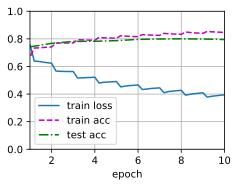

In [10]:
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)